In [2]:
import numpy as np
import cupy as cp
# import cupyx.scipy.signal as signal
import scipy
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import pywt
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

from astropy.modeling import models, fitting
import astropy.units as u
from astropy import constants as const
from astropy.stats import gaussian_sigma_to_fwhm,gaussian_fwhm_to_sigma

import datetime
import pickle
import importlib
import json
import time
import glob
from skimage.metrics import structural_similarity as ssim

from eve_ops.gaussian_fit_eve import gaussian_fit_eve
from eve_ops.data.eve_const import  wavelength_list_eve

## preparations

In [2]:
with open('D:\py_repo\EVE-spectrum-correction\Chapter4_v2\\basic_ops\eve_ops\data\daily_df.pkl', 'rb') as file:
    daily_df=pickle.load(file)
daily_df.reset_index(inplace=True)
daily_df

,time,median_of_mean,median_of_stddev,median_of_amplitude,stddev_of_mean,stddev_of_stddev,stddev_of_amplitude,available_data
0,2010-04-30,30.374138,0.028910,0.006518,0.000175,0.000076,0.000058,8570
1,2010-05-01,30.374133,0.028986,0.006556,0.000199,0.000070,0.000052,8579
2,2010-05-02,30.374000,0.029030,0.006503,0.000210,0.000070,0.000048,8579
3,2010-05-03,30.373922,0.029038,0.006513,0.000206,0.000102,0.000049,8640
4,2010-05-04,30.373876,0.029006,0.006656,0.000195,0.000092,0.000059,8578
...,...,...,...,...,...,...,...,...
1702,2014-12-27,NaN,NaN,NaN,NaN,NaN,NaN,0
1703,2014-12-28,NaN,NaN,NaN,NaN,NaN,NaN,0
1704,2014-12-29,NaN,NaN,NaN,NaN,NaN,NaN,0
1705,2014-12-30,NaN,NaN,NaN,NaN,NaN,NaN,0


In [9]:
daily_df.set_index('time')

,median_of_mean,median_of_stddev,median_of_amplitude,stddev_of_mean,stddev_of_stddev,stddev_of_amplitude,available_data
time,,,,,,,
2010-04-30,30.374138,0.028910,0.006518,0.000175,0.000076,0.000058,8570
2010-05-01,30.374133,0.028986,0.006556,0.000199,0.000070,0.000052,8579
2010-05-02,30.374000,0.029030,0.006503,0.000210,0.000070,0.000048,8579
2010-05-03,30.373922,0.029038,0.006513,0.000206,0.000102,0.000049,8640
2010-05-04,30.373876,0.029006,0.006656,0.000195,0.000092,0.000059,8578
...,...,...,...,...,...,...,...
2014-12-27,NaN,NaN,NaN,NaN,NaN,NaN,0
2014-12-28,NaN,NaN,NaN,NaN,NaN,NaN,0
2014-12-29,NaN,NaN,NaN,NaN,NaN,NaN,0


In [14]:
t0=pd.to_datetime('2010-06-01 00:00:00')
t1=pd.to_datetime('2014-06-01 00:00:00')

df=daily_df.set_index('time')
df=df[(df.index>=t0)&(df.index<t1)]

In [17]:
def repair_nan(intput_array):
    # Find indices of NaN values
    array_with_nan=intput_array.copy()
    nan_indices = np.isnan(array_with_nan)

    # Create x values for interpolation (excluding NaNs)
    x_interp = np.arange(len(array_with_nan))
    x_interp_non_nan = x_interp[~nan_indices]

    # Interpolate to fill NaN values using known values
    interpolation_function = interp1d(x_interp_non_nan, array_with_nan[~nan_indices], fill_value="extrapolate")
    array_with_nan[nan_indices] = interpolation_function(x_interp[nan_indices])

    return array_with_nan

In [19]:
#interpolate the missing values, the days failed to get one data
repaired_daily_df={'time':df.index,
                  'mean':repair_nan(df['median_of_mean']),
                    'amplitude':repair_nan(df['median_of_amplitude']),
                   'stddev':repair_nan(df['median_of_stddev'])
                                    }

In [21]:
repaired_daily_df=pd.DataFrame(repaired_daily_df)
repaired_daily_df

,time,mean,amplitude,stddev
time,,,,
2010-06-01,2010-06-01,30.372410,0.006253,0.028617
2010-06-02,2010-06-02,30.372425,0.006185,0.028615
2010-06-03,2010-06-03,30.372540,0.006150,0.028580
2010-06-04,2010-06-04,30.374629,0.006146,0.028537
2010-06-05,2010-06-05,30.374757,0.006080,0.028548
...,...,...,...,...
2014-05-27,2014-05-27,30.372243,0.006427,0.030993
2014-05-28,2014-05-28,30.372040,0.006336,0.031012
2014-05-29,2014-05-29,30.371838,0.006244,0.031030


In [25]:
with open('D:\py_repo\EVE-spectrum-correction\Chapter4_v2\\basic_ops\eve_ops\data\\repaired_daily_df.pkl', 'wb') as file:
    pickle.dump(repaired_daily_df,file)

In [3]:
with open('D:\py_repo\EVE-spectrum-correction\Chapter4_v2\\basic_ops\eve_ops\data\\repaired_daily_df.pkl', 'rb') as file:
    daily_df=pickle.load(file)
daily_df

,time,mean,amplitude,stddev
time,,,,
2010-06-01,2010-06-01,30.372410,0.006253,0.028617
2010-06-02,2010-06-02,30.372425,0.006185,0.028615
2010-06-03,2010-06-03,30.372540,0.006150,0.028580
2010-06-04,2010-06-04,30.374629,0.006146,0.028537
2010-06-05,2010-06-05,30.374757,0.006080,0.028548
...,...,...,...,...
2014-05-27,2014-05-27,30.372243,0.006427,0.030993
2014-05-28,2014-05-28,30.372040,0.006336,0.031012
2014-05-29,2014-05-29,30.371838,0.006244,0.031030


## Wavelet

In [147]:
def plot(t,signal):
    
    dt = (t[1] - t[0])/np.timedelta64(1, 's')
    waveletname='cmor'
    scales = np.arange(1, len(t)//5)
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, sampling_period=dt)
    
    period = 1. / frequencies
    power = (abs(coefficients)) ** 2
    levels =np.linspace(start=-30,stop=0,endpoint=True)
    
    fig, ax = plt.subplots()
    ax.imshow(np.log2(power),cmap='seismic',origin='lower')
    
    fig, ax = plt.subplots(figsize=(10,6))
    im=ax.contourf(t, np.log2(period), np.log2(power),  levels=levels,
                extend='both',cmap='seismic')
    plt.colorbar(im)


    yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))

    ax.set_yticks(np.log2(yticks))
    ax.set_yticklabels(yticks//86400)
    ax.invert_yaxis()
    ax.set_title('Wavelet Transform (Power Spectrum) of signal')
    ax.set_ylabel('Period (days)')
    ax.set_xlabel('Time')
    # ylim = ax.get_ylim()
    # ax.set_ylim(ylim[0], -1)

    fig, ax = plt.subplots()
    ax.specgram(signal,Fs=1/dt);
    ax.set_ylabel('Frequency (Hertz)')

    print(dt)

86400.0


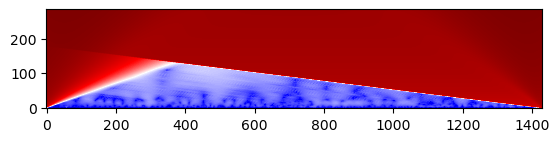

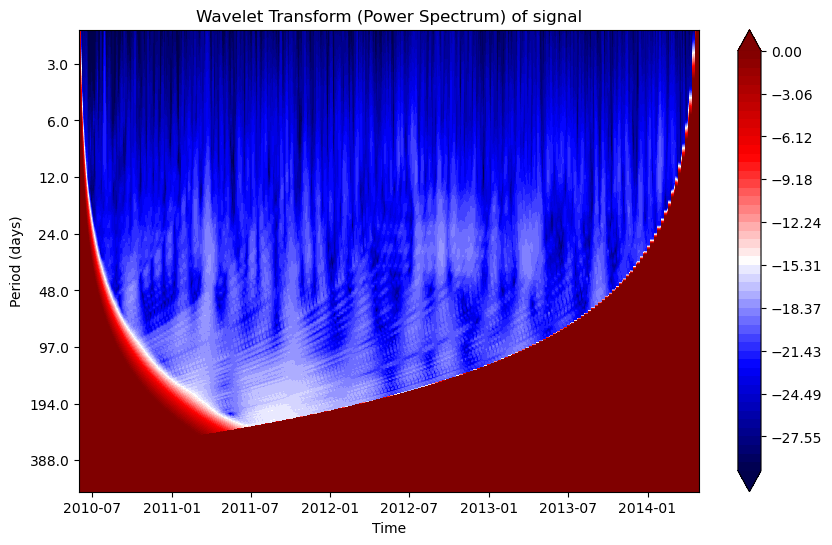

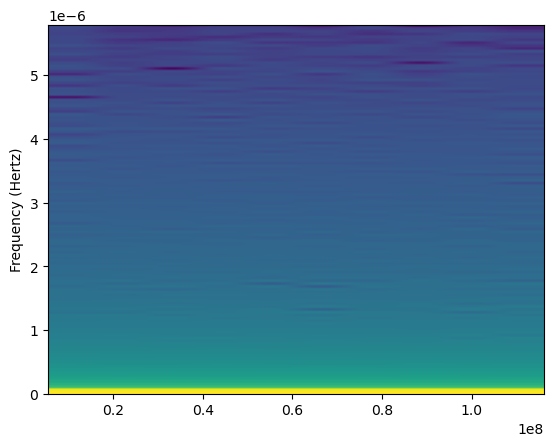

In [148]:
t=df.index
signal=df['median_of_mean'].values
plot(t,repair_nan(signal))

In [36]:
def wavelet_plot(t,signal):
    
    dt = (t[1] - t[0])/np.timedelta64(1, 's')
    waveletname='cmor'
    scales = np.linspace(5,25,endpoint=True)
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, sampling_period=dt)
    
    period = 1. / frequencies
    power = (abs(coefficients)) ** 2
    levels =np.linspace(start=-40,stop=0,endpoint=True)
    
    
    fig, ax = plt.subplots(figsize=(8,5))
    im=ax.contourf(t, np.log2(period), np.log2(power),  levels=levels,
                extend='both',cmap='seismic')
    plt.colorbar(im)


    yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))

    ax.set_yticks(np.log2(yticks))
    ax.set_yticklabels(yticks//86400)
    ax.invert_yaxis()
    ax.set_title('Wavelet Transform (Power Spectrum) of signal')
    ax.set_ylabel('Period (days)')
    ax.set_xlabel('Time')

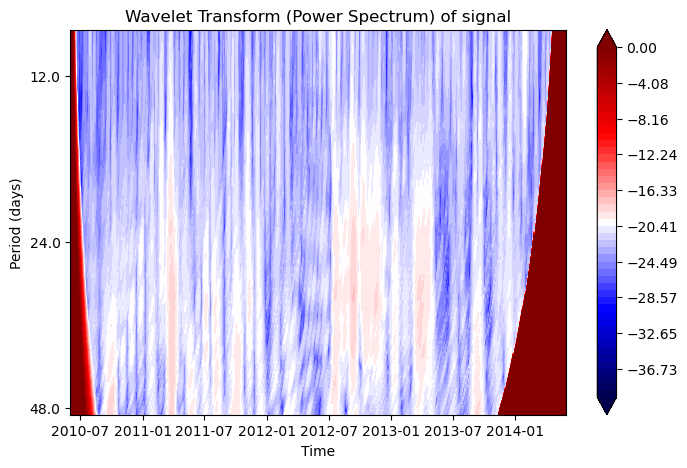

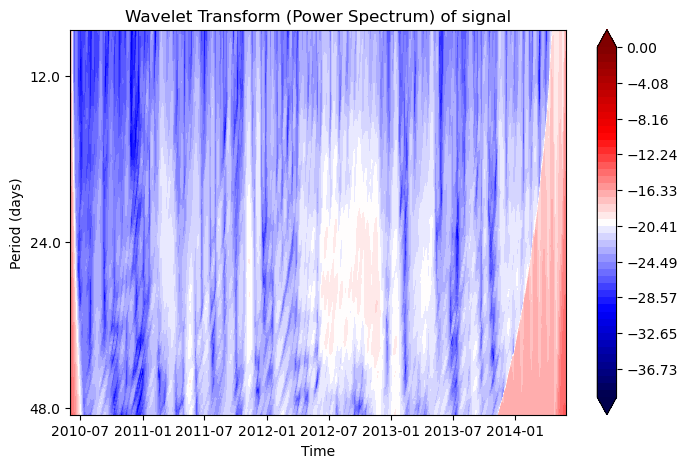

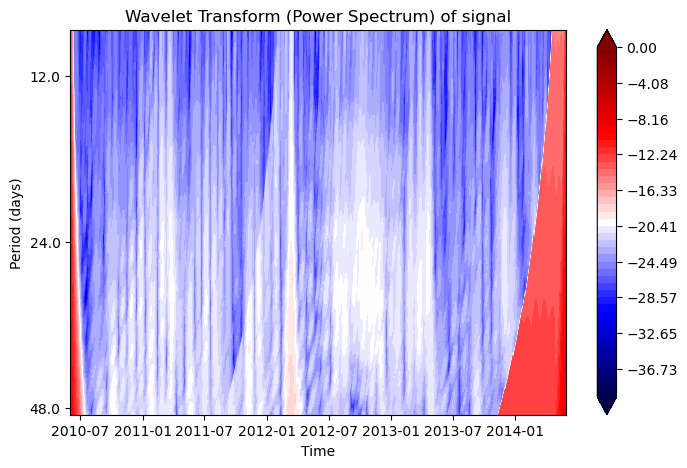

In [37]:
df=daily_df
t=df.index
signal=df['mean'].values
wavelet_plot(t,signal)

signal=df['amplitude'].values
wavelet_plot(t,signal)

signal=df['stddev'].values
wavelet_plot(t,signal)

In [46]:

def plotly_wavelet(t,signal):
    dt = (t[1] - t[0])/np.timedelta64(1, 's')
    waveletname='cmor'
    scales = np.arange(1, len(t)//48)
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, sampling_period=dt)
    
    period = 1. / frequencies
    power = (abs(coefficients)) ** 2
    levels =np.linspace(start=-50,stop=0,endpoint=True)
    
    # Assuming the same variables and levels are defined as in the original code
    yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
    log2_yticks = np.log2(yticks)
    
    # log2_yticks=np.linspace(-40,0)
    # yticks=2**log2_yticks
    
    fig = go.Figure(data =
             go.Contour(z=np.log2(power),
                        x=t,
                        y=np.log2(period),
                        # colorscale='heatmap',
                        contours=dict(
                                    # start=levels[0], 
                                    # end=levels[-1], 
                                    start=-40, 
                                    end=0,
                                    size=np.diff(levels)[0],
                                    ),
                        
                        # connectgaps=True,
                        line_width=0,
                        
                        colorscale='picnic',
                       ),
                    
            
            
             )

    fig.update_layout(
        title='Wavelet Transform (Power Spectrum) of signal',
        width=800,
        height=500,
        xaxis_title='Time',
        yaxis_title='Period (days)',
        yaxis=dict(
            tickmode = 'array',
            tickvals = log2_yticks,
            ticktext = yticks//86400,
            autorange="reversed"
        )
    )

    fig.show()


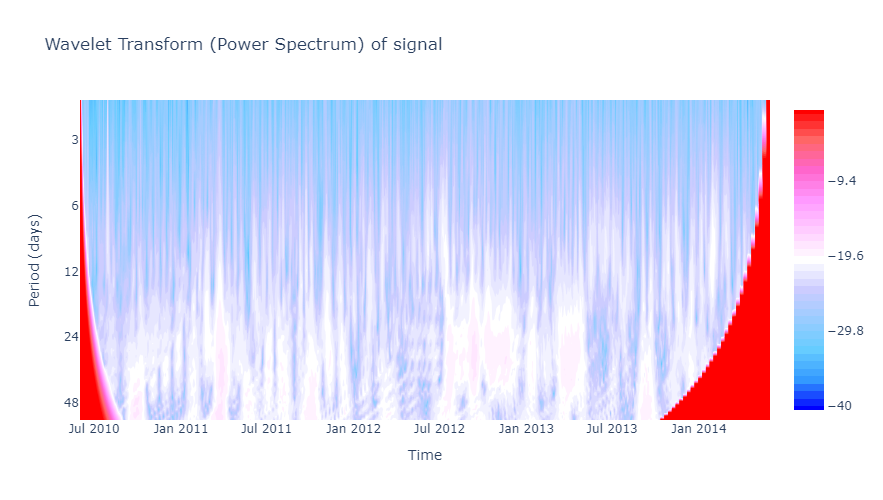

In [47]:
t=df.index
signal=df['mean'].values
plotly_wavelet(t,signal)

In [49]:
px.colors

TypeError: 'module' object is not callable

In [13]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
a=np.linspace(-1,1,1000,endpoint=True)
b=np.full(a.shape,np.nan)

In [6]:
b[np.where(a>=0)]=a[np.where(a>=0)]**2

In [15]:
b[a>=0]=a[a>=0]**2
b[a<0]=-a[a<0]**2

Text(0, 0.5, 'v')

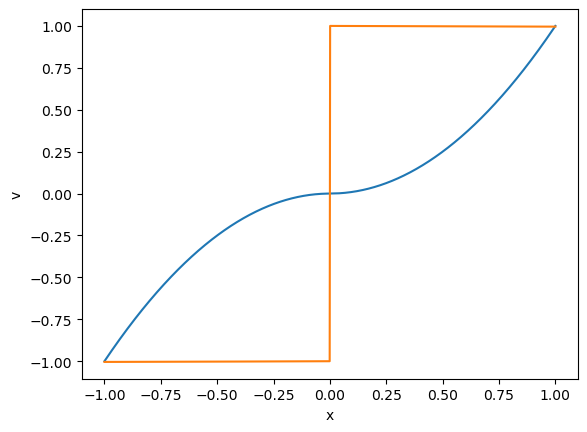

In [28]:
fig,ax=plt.subplots()
ax.plot(a,b)
ax.plot(a,)
ax.set_xlabel('x')
ax.set_ylabel('v')

In [53]:
n=100
theta=np.linspace(-1/n,1/n,1000,endpoint=True)
v=n**(1)*np.sin(theta)

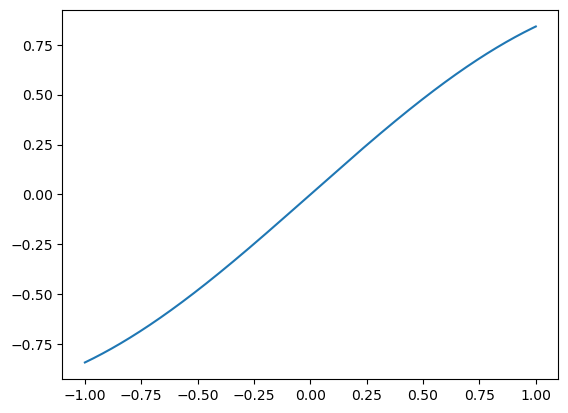

In [55]:
plt.plot(a,np.sin(a))

C:\Users\14902\AppData\Local\Temp\ipykernel_24960\2624695946.py:21: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(x_2d, y_2d, doppler_shift_2d, shading='auto', cmap=plt.cm.RdBu_r)


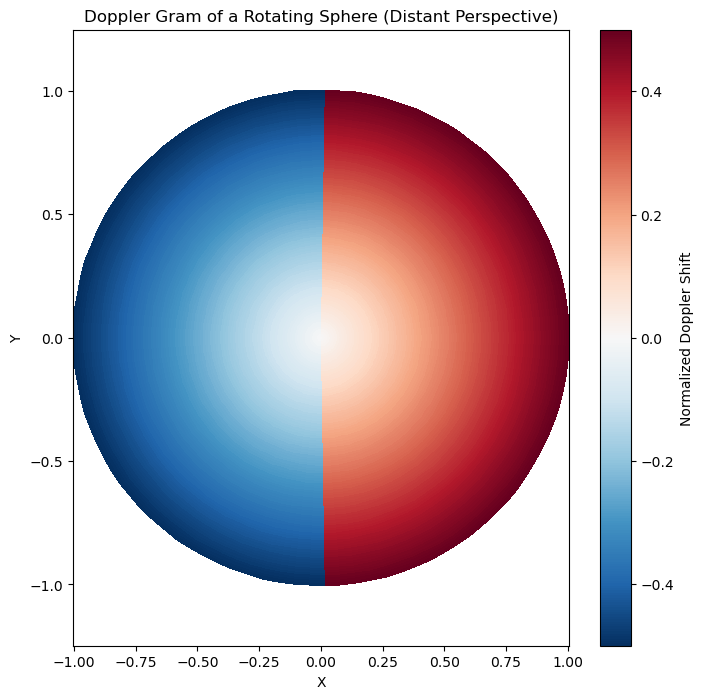

In [59]:
doppler_shift_2d.shape

(100, 100)